In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


import os, cv2, glob, random, datetime
from PIL import Image
from os import listdir
from os.path import isfile, isdir, join

import gradio as gr

In [2]:
honey_images=[]
for folders in glob.glob("./coffeebeans/Honey/*"):
    print(folders,"圖片讀取中…") 
    for filename in os.listdir(folders):
        try:
            img = cv2.imread(os.path.join(folders, filename))
            img = cv2.resize(img, (256, 256))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                honey_images.append(img)      
        except:
            pass
print('圖片讀取完畢！')

./coffeebeans/Honey/Guatemala 圖片讀取中…
圖片讀取完畢！


In [3]:
natural_images=[]
for folders in glob.glob("./coffeebeans/Natural/*"):
    print(folders,"圖片讀取中…") 
    for filename in os.listdir(folders):
        try:
            img = cv2.imread(os.path.join(folders, filename))
            img = cv2.resize(img, (256, 256))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                natural_images.append(img)      
        except:
            pass
print('圖片讀取完畢！')

./coffeebeans/Natural/test 圖片讀取中…
./coffeebeans/Natural/Ethiopia 圖片讀取中…
圖片讀取完畢！


In [4]:
washed_images=[]
for folders in glob.glob("./coffeebeans/Washed/*"):
    print(folders,"圖片讀取中…") 
    for filename in os.listdir(folders):
        try:
            img = cv2.imread(os.path.join(folders, filename))
            img = cv2.resize(img, (256, 256))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                washed_images.append(img)      
        except:
            pass
print('圖片讀取完畢！')

./coffeebeans/Washed/Guatemala 圖片讀取中…
./coffeebeans/Washed/Nicaragua 圖片讀取中…
./coffeebeans/Washed/Panama 圖片讀取中…
圖片讀取完畢！


In [5]:
print(len(honey_images))
print(len(natural_images))
print(len(washed_images))

120
58
383


In [6]:
type(honey_images)

list

In [7]:
honey_dir = honey_images
natural_dir = natural_images
washed_dir = washed_images
coffee_folders = [honey_dir , natural_dir , washed_dir]

In [8]:
len(coffee_folders)

3

In [9]:
len(coffee_folders[0])

120

In [10]:
data = []
target = []
for i in range(3):
    thedir = coffee_folders[i]
    #myna_fnames = os.listdir(thedir)
    for j in range(len(thedir)):
        img = thedir[j]
        #x = img_to_array(img)
        data.append(img)
        target.append(i)

In [11]:
data = np.array(data)
data.shape

(561, 256, 256, 3)

In [12]:
#CSVLogger
folder = './coffeebeans/save_coffee_record'
if not os.path.exists(folder):
    os.mkdir(folder)
    
csv_path = './coffeebeans/save_coffee_record/train_imdb_log.csv'  # 檔案儲存的位置

csvlogger = callbacks.CSVLogger(csv_path, 
                                separator=',', # 檔案中的分隔字串
                                append=False)  # 是否覆蓋已存在的檔案

In [13]:
#ModelCheckpoint
folder = './coffeebeans/save_coffee_model'
if not os.path.exists(folder):
    os.mkdir(folder)
    
model_path = './coffeebeans/save_coffee_model/coffee_beans_model.h5'  # 模型儲存的位置

# 建立 Checkpoint
checkpoint = callbacks.ModelCheckpoint(model_path,
                                       verbose=1,
                                       monitor='val_loss',   # 儲存模型的觀察指標
                                       save_best_only=True,  # 是否只儲存最好的
                                       mode='min')           # 與指標搭配模式

In [14]:
#EarlyStopping
n_patience = 15  # 訓練過程經過 n_patience 次沒有進步就不忍了，數字要大於下面的ReduceLROnPlateau
early_stopping = callbacks.EarlyStopping(monitor='val_loss',   # 停止訓練的觀察指標
                                         patience=n_patience,
                                         verbose=1)

In [15]:
#ReduceLROnPlateau
lr_patience = 13 # 訓練過程經過 lr_patience 次沒有進步，就會調整學習率
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', # 調整學習率的觀察指標
                                        factor=0.1, # 縮放學習率的值，lr = lr*factor
                                        patience=lr_patience, 
                                        min_lr=1e-4, # 學習率縮放的最小值
                                        verbose=1,
                                        mode='min') # 與指標搭配模式

In [16]:
%load_ext tensorboard

In [17]:
logdir = os.path.join('coffeelogs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = callbacks.TensorBoard(logdir,             # 訓練記錄儲存的位置
                                    histogram_freq=1)   # 每一個epoch統計1次參數分布的直方圖

In [18]:
data = np.array(data)
data.shape

(561, 256, 256, 3)

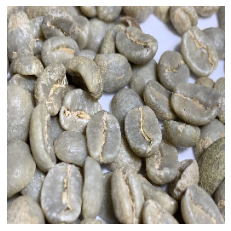

In [19]:
n = 500
plt.imshow(data[n])
plt.axis('off');

In [20]:
x_train = preprocess_input(data)

In [21]:
target[n]

2

In [22]:
y_train = to_categorical(target, 3)

In [23]:
resnet = ResNet50V2(include_top=False, pooling="avg")

2022-08-13 14:20:51.193540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-13 14:20:51.193815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [24]:
model = Sequential()
model.add(resnet)
model.add(Dense(3, activation='softmax'))
resnet.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [26]:
callbacks_list = [csvlogger, checkpoint, early_stopping, reduce_lr, tensorboard]

In [27]:
history = model.fit(x_train, y_train, 
                    batch_size=23, 
                    epochs=100,
                    verbose=1,
                    validation_split=0.1,
                    callbacks = callbacks_list)

Epoch 1/100


2022-08-13 14:20:52.707557: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-13 14:20:53.966905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.6032

2022-08-13 14:20:57.927027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.41661, saving model to ./coffeebeans/save_coffee_model/coffee_beans_model.h5
22/22 [==============================] - 8s 265ms/step - loss: 0.9424 - accuracy: 0.6032 - val_loss: 0.4166 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.8532
Epoch 2: val_loss improved from 0.41661 to 0.20033, saving model to ./coffeebeans/save_coffee_model/coffee_beans_model.h5
22/22 [==============================] - 5s 233ms/step - loss: 0.4705 - accuracy: 0.8532 - val_loss: 0.2003 - val_accuracy: 0.9649 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.8829
Epoch 3: val_loss did not improve from 0.20033
22/22 [==============================] - 5s 212ms/step - loss: 0.3445 - accuracy: 0.8829 - val_loss: 0.2581 - val_accuracy: 0.9298 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.

22/22 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 1.0000
Epoch 28: val_loss did not improve from 0.14941
22/22 [==============================] - 5s 214ms/step - loss: 0.0382 - accuracy: 1.0000 - val_loss: 0.1743 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 29/100
22/22 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9980
Epoch 29: val_loss improved from 0.14941 to 0.14401, saving model to ./coffeebeans/save_coffee_model/coffee_beans_model.h5
22/22 [==============================] - 5s 224ms/step - loss: 0.0376 - accuracy: 0.9980 - val_loss: 0.1440 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 30/100
22/22 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 1.0000
Epoch 30: val_loss did not improve from 0.14401
22/22 [==============================] - 5s 212ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.1765 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 31/100
22/22 [==============================] - ETA: 0s - loss: 0.03

In [28]:
y_predict = np.argmax(model.predict(x_train), -1)

2022-08-13 14:24:44.436517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 4s 155ms/step


In [29]:
loss, acc = model.evaluate(x_train, y_train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

18/18 [==============================] - 3s 156ms/step - loss: 0.0317 - accuracy: 0.9929
Loss: 0.03167185187339783
Accuracy: 0.9928699135780334


In [30]:
labels = ["蜜處理", "日曬", "水洗"]

In [31]:
def classify_image(inp):
    inp = inp.reshape((-1, 256, 256, 3))
    inp = preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(3)}

In [32]:
def classify_image(inp):
    inp = inp.reshape((-1, 256, 256, 3))
    inp = preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(3)}

In [33]:
image = gr.Image(shape=(256, 256), label="生豆照片")
label = gr.Label(num_top_classes=3, label="AI辨識結果")
some_text="我能辨識生豆處理法。找張生豆照片來考我吧!"

In [34]:
gr.Interface(fn=classify_image, 
             inputs=image, 
             outputs=label,
             title="AI 生豆辨識機",
             description=some_text,
             ).launch(share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://17146.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x17c5f3490>,
 'http://127.0.0.1:7860/',
 'https://17146.gradio.app')

In [35]:
model.save('coffee_beans_model_v7.h5')

In [36]:
# 訓練結束後可以使用魔術指令開啟tensorboard
%tensorboard --logdir coffeelogs

Reusing TensorBoard on port 6006 (pid 96338), started 1 day, 18:16:01 ago. (Use '!kill 96338' to kill it.)

1/1 [==============================] - 0s 169ms/step
